In [1]:
import numpy as np
from qutip import *
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
from scipy.special import log_softmax
from scipy.special import softmax
import statistics 
from numpy import diff
import random
from scipy.optimize import curve_fit
import math
from scipy.signal import find_peaks
from scipy.integrate import odeint, solve_ivp, RK45
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
import math

example_name = 'CNOT'

In [2]:

math.comb(4,2)

6

In [3]:
cnot_data = np.loadtxt('F_0.9994044301600786_1amp_CNOT_n_ts_250_5_level.txt')
cnot_control_1 = cnot_data[:,1]
cnot_control_2 = cnot_data[:,2]
B = [cnot_control_1, cnot_control_2]

In [4]:
# no. of levels for each transmon.
N = 3

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

# defines a list of a_i's for all 2 qubits.
a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

In [5]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
f = [f_1, f_2]
delta = [delta_1, delta_2]
J = [[ 0.0, 4.03],[4.03, 0.0]]

In [6]:
def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[1])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 26.5*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,26.5*(2*np.pi)*Qobj(a[1].dag() + a[1])/2]

In [7]:
Ham = Hamiltonian(f, delta, J, N)
Ham
Hc = [26.5*2*np.pi*Qobj(a[0].dag() + a[0])/2, 26.5*2*np.pi*Qobj(a[1].dag() + a[1])/2]

In [8]:
H_array = []
steps = len(B[0])
delta_t = 0.001

for i in range(steps):
    H_array.append(Ham + B[0][i]*Hc[0] + B[1][i]*Hc[1]) #for now, the control is just (a + a_dagger) on the 0th qubit.

In [16]:
SCALING=1
U_cnot = [(-SCALING*1j*h*delta_t).expm() for h in H_array] # the unitary evolution operator for each time step.
Total_Ucnot = identity_matrix # the total unitary evolution operator (U). It is initialised to the identity matrix.
for i in range(steps):
    Total_Ucnot = U_cnot[i]*Total_Ucnot # at each step, we multiply the total U with the unitary evolution operator for that time step.[Time-ordered product]
Total_Ucnot/Total_Ucnot[0,0] # normalising the total unitary evolution operator.

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -1.61320438e-03-5.14279363e-03j
  -6.20561649e-03-1.08018324e-02j -9.20939491e-03-6.48946277e-03j
   2.61300896e-03-6.16242830e-03j  3.54588299e-04+6.99541078e-04j
   3.09658596e-03+4.17775045e-03j  2.09008506e-03+4.56167290e-03j
   3.69364827e-05-1.08533755e-04j]
 [ 1.20008336e-03-4.95348541e-03j  9.99461100e-01-1.67908278e-03j
  -2.22375465e-03-7.12543655e-04j -2.44418941e-02-1.51384095e-03j
   1.68076966e-02-3.42031528e-04j  1.61423260e-03+7.58212317e-04j
   1.33278337e-02-4.48597880e-03j  1.68038711e-02+9.29811505e-03j
  -1.73779187e-05-5.85678221e-05j]
 [ 1.17851129e-02-4.35930054e-03j  2.67498075e-03+9.33293388e-04j
   7.69192782e-01+6.38534575e-01j  1.50314261e-02+1.39964445e-05j
  -1.18009855e-02-9.71776696e-03j -1.22258976e-02-1.05790185e-02j
   1.22705884e-03+5.14367912e-04j  1.03130360e-03+1.85390136e-03j
   7.29225446e-03+8.85890146e-03j]

In [17]:
# from qutip.qip.operations import swap,cnot
# SWAP = swap().full()
# SWAP = Qobj(SWAP)
# CNOT = cnot().full()
# CNOT = Qobj(CNOT)

In [18]:
CNOT = np.identity(N**2)
CNOT[N][N] = 0
CNOT[N+1][N+1] = 0
CNOT[N][N+1] = 1
CNOT[N+1][N] = 1
CNOT = Qobj(CNOT)

SWAP = np.identity(N**2)
SWAP[1][N] = 1
SWAP[N][N] = 0
SWAP[1][1] = 0
SWAP[N][1] = 1
SWAP = Qobj(SWAP)

SWAP

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [19]:
tim=[0.001,
     0.104,
     0.104,
     0.208,
     0.104,
     0.104,
     0.104,
     0.104,
     0.104,
     0.104,
     0.104,
     0.104,
     0.052,
     0.052,
     0.052,
     0.052,
     0.156,
     0.156,
     0.156,
     0.156,
     0.156,
     0.156,
     0.156,
     0.156]

cllist=[['I'],
['X180'],
['Y180'],
['Y180','X180'],
['X90','Y90'],
['X90','mY90'],
['mX90','Y90'],
['mX90','mY90'],
['Y90','X90'],
['Y90','mX90'],
['mY90','X90'],
['mY90','mX90'],
['X90'],
['Y90'],
['mY90'],
['mX90'],
['mX90','Y90','X90'],
['mX90','mY90','X90'],
['X180','Y90'],
['X180','mY90'],
['Y180','X90'],
['Y180','mX90'],
['X90','Y90','X90'],
['mX90','Y90','mX90']]

# cl1=[qeye(N**2),
#      X180,
#      Y180,
#      Y180*X180,
#      X90*Y90,
#      X90*mY90,
#      mX90*Y90,
#      mX90*mY90,
#      Y90*X90,
#      Y90*mX90,
#      mY90*X90,
#      mY90*mX90,
#      X90,
#      Y90,
#      mY90,
#      mX90,
#      mX90*Y90*X90,
#      mX90*mY90*X90,
#      X180*Y90,
#      X180*mY90,
#      Y180*X90,
#      Y180*mX90,
#      X90*Y90*X90,
#      mX90*Y90*mX90]

# cl2=[qeye(N**2),
#      SWAP*X180*SWAP,
#      SWAP*Y180*SWAP,
#      SWAP*Y180*X180*SWAP,
#      SWAP*X90*Y90*SWAP,
#      SWAP*X90*mY90*SWAP,
#      SWAP*mX90*Y90*SWAP,
#      SWAP*mX90*mY90*SWAP,
#      SWAP*Y90*X90*SWAP,
#      SWAP*Y90*mX90*SWAP,
#      SWAP*mY90*X90*SWAP,
#      SWAP*mY90*mX90*SWAP,
#      SWAP*X90*SWAP,
#      SWAP*Y90*SWAP,
#      SWAP*mY90*SWAP,
#      SWAP*mX90*SWAP,
#      SWAP*mX90*Y90*X90*SWAP,
#      SWAP*mX90*mY90*X90*SWAP,
#      SWAP*X180*Y90*SWAP,
#      SWAP*X180*mY90*SWAP,
#      SWAP*Y180*X90*SWAP,
#      SWAP*Y180*mX90*SWAP,
#      SWAP*X90*Y90*X90*SWAP,
#      SWAP*mX90*Y90*mX90*SWAP]
cllist[23]

['mX90', 'Y90', 'mX90']

In [20]:
def Hamiltoniand(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[i])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + 0*(2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_dd = Hamiltoniand(f, delta, J, N)

In [21]:
ggg50=((6.3269/0.1936)*np.array([0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347])
      ).tolist()
print(ggg50,len(ggg50))

[0.04204232188477656, 0.11428287960561416, 0.2779845853419365, 0.6050695690109885, 1.1785145967689838, 2.0540436957295434, 3.2035348129708674, 4.470892989177985, 5.583469652962478, 6.239633806927085, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.3269, 6.239633806927085, 5.583469652962478, 4.470892989177985, 3.2035348129708674, 2.0540436957295434, 1.1785145967689838, 0.6050695690109885, 0.2779845853419365, 0.11428287960561416, 0.04204232188477656] 52


In [22]:
ggg100=((5.463658/0.1936)*np.array([0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347])
       ).tolist()
print(ggg100,len(ggg100))

[0.0363060690550403, 0.09869012777509532, 0.24005637888699896, 0.5225138995848582, 1.017718109145653, 1.7737900505021866, 2.7664446425843274, 3.8608845165035337, 4.8216612617815455, 5.388298403054832, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658, 5.463658,

In [23]:
def gamma1(t):
    return(1-np.exp(-t/T1_1))
def gamma2(t):
    return(1-np.exp(-t/T1_2))
def lam1(t):
    return(1-np.exp(-2*t/T2star_1))
def lam2(t):
    return(1-np.exp(-2*t/T2star_2))

In [24]:
def AD(t):
    AD1=[]
    AD2=[]
    for i in range(N):
        sum1=Qobj(np.zeros([N,N]))
        sum2=Qobj(np.zeros([N,N]))
        for j in range(i,N):
            sum1=sum1+np.sqrt(math.comb(j,i)*((1-gamma1(t))**(j-i))*gamma1(t)**i)*basis(N,j-i)*basis(N,j).dag()
            sum2=sum2+np.sqrt(math.comb(j,i)*((1-gamma2(t))**(j-i))*gamma2(t)**i)*basis(N,j-i)*basis(N,j).dag()
        AD1.append(tensor(sum1,qeye(N)))
        AD2.append(tensor(qeye(N),sum2))
    return([AD1,AD2])

In [25]:
def PD(t):
    PD1=[]
    PD2=[]
    som1=np.identity(N)
    som1[1][1]=np.sqrt(1-lam1(t))
    som1[2][2]=np.sqrt(1-lam1(4*t))
    som2=np.identity(N)
    som2[1][1]=np.sqrt(1-lam2(t))
    som2[2][2]=np.sqrt(1-lam2(4*t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))

    som1=np.zeros([N,N])
    som1[1][1]=np.sqrt(lam1(t))
    som2=np.zeros([N,N])
    som2[1][1]=np.sqrt(lam2(t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))

    som1=np.zeros([N,N])
    som1[2][2]=np.sqrt(lam1(4*t))
    som2=np.zeros([N,N])
    som2[2][2]=np.sqrt(lam2(4*t))
    PD1.append(tensor(Qobj(som1),qeye(N)))
    PD2.append(tensor(qeye(N),Qobj(som2)))
    return([PD1,PD2])

In [26]:
# for i in range(111):
#     c1=np.random.choice(cl1,1)[0]
#     c2=np.random.choice(cl2,1)[0]
#     E0=c1 * c2 * Ucnot *E0*(c1*c2 * Ucnot).dag()
#     E0=Qobj(PD(0.3)[0][0].full())*E0*Qobj(((PD(0.3)[0][0]).dag()).full())+Qobj(PD(0.3)[0][1].full())*E0*Qobj(((PD(0.3)[0][1]).dag()).full())
#     E0=Qobj(PD(0.3)[1][0].full())*E0*Qobj(((PD(0.3)[1][0]).dag()).full())+Qobj(PD(0.3)[1][1].full())*E0*Qobj(((PD(0.3)[1][1]).dag()).full())
#     print(E0.tr())

In [27]:
def MAP(rho,t):
    A=AD(t)
    P=PD(t)
    for i in range(len(A)):
        sum = Qobj(np.zeros([N**2,N**2]))
        for j in range(len(A[i])):
            sum = sum + Qobj(A[i][j].full())*rho*Qobj(((A[i][j]).dag()).full())
        rho = sum
    for i in range(len(P)):
        sum = Qobj(np.zeros([N**2,N**2]))
        for j in range(len(P[i])):
            sum= sum + Qobj(P[i][j].full())*rho*Qobj(((P[i][j]).dag()).full())
        rho = sum
    #print(rho.tr())
    return(rho)

In [28]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
f_3 = 5.03648*(10**3)
f_4 = 4.96961*(10**3)
f_5 = 4.83780*(10**3)
f_6 = 4.92466*(10**3)
delta_1 = -271
delta_2 = -269
delta_3 = -268
delta_4 = -269
delta_5 = -280
delta_6 = -271
# all the times (T) are in microseconds. Therefore, 1/T would be in MHz. [NOT INCLUDED rn.]
T1_1 = 44
T1_2 = 30
T1_3 = 25
T1_4 = 37
T1_5 = 1.6
T1_6 = 57
T2star_1 = 35
T2star_2 = 21
T2star_3 = 11
T2star_4 = 28
T2star_5 = 2.2
T2star_6 = 26
T2_1 = 40
T2_2 = 42
T2_3 = 27
T2_4 = 30
T2_5 = 2
T2_6 = 28


In [29]:
from scipy.linalg import expm
def uni_evo(st,p1,p2,h1,h2,t):
    ut=qeye(N**2)
    for i in range(len(p1)):
        u1=Qobj(expm(-0.001*1j*(H_dd.full()+p1[i]*h1[i].full()+p2[i]*h2[i].full())))
        ut=u1*ut
        st=MAP(u1*st*u1.dag(),0.001*t)
    #print(ut)
    return([st,ut])

In [30]:
def make_pulse(n,m,t,sta):
    l=int(max(tim[n],tim[m])*1000)
    pul1=np.zeros(l)
    pul2=np.zeros(l)
    tpul1=[]
    tpul2=[]
    ham1=[]
    ham2=[]
    for i in cllist[n]:
        if i=='I':
            tpul1=tpul1+[1]
            ham1=ham1+[(0)*Qobj(a[0].dag() + a[0])/2]
        elif i=='X90':
            tpul1=tpul1+ggg50
            ham1=ham1+[(2*np.pi)*Qobj(a[0].dag() + a[0])/2]*len(ggg50)
        elif i=='Y90':
            tpul1=tpul1+ggg50
            ham1=ham1+[(2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j)]*len(ggg50)
        elif i=='mX90':
            tpul1=tpul1+ggg50
            ham1=ham1+[(-2*np.pi)*Qobj(a[0].dag() + a[0])/2]*len(ggg50)
        elif i=='mY90':
            tpul1=tpul1+ggg50
            ham1=ham1+[(-2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j)]*len(ggg50)
        elif i=='X180':
            tpul1=tpul1+ggg100
            ham1=ham1+[(2*np.pi)*Qobj(a[0].dag() + a[0])/2]*len(ggg100)
        elif i=='Y180':
            tpul1=tpul1+ggg100
            ham1=ham1+[(2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j)]*len(ggg100)
        elif i=='mX180':
            tpul1=tpul1+ggg100
            ham1=ham1+[(-2*np.pi)*Qobj(a[0].dag() + a[0])/2]*len(ggg100)
        elif i=='mY180':
            tpul1=tpul1+ggg100
            ham1=ham1+[(-2*np.pi)*Qobj(-a[0].dag() + a[0])/(2*1j)]*len(ggg100)
    for i in cllist[m]:
        if i=='I':
            tpul2=tpul2+[1]
            ham2=ham2+[(0)*Qobj(a[0].dag() + a[0])/2]
        elif i=='X90':
            tpul2=tpul2+ggg50
            ham2=ham2+[(2*np.pi)*Qobj(a[1].dag() + a[1])/2]*len(ggg50)
        elif i=='Y90':
            tpul2=tpul2+ggg50
            ham2=ham2+[(2*np.pi)*Qobj(-a[1].dag() + a[1])/(2*1j)]*len(ggg50)
        elif i=='mX90':
            tpul2=tpul2+ggg50
            ham2=ham2+[(-2*np.pi)*Qobj(a[1].dag() + a[1])/2]*len(ggg50)
        elif i=='mY90':
            tpul2=tpul2+ggg50
            ham2=ham2+[(-2*np.pi)*Qobj(-a[1].dag() + a[1])/(2*1j)]*len(ggg50)
        elif i=='X180':
            tpul2=tpul2+ggg100
            ham2=ham2+[(2*np.pi)*Qobj(a[1].dag() + a[1])/2]*len(ggg100)
        elif i=='Y180':
            tpul2=tpul2+ggg100
            ham2=ham2+[(2*np.pi)*Qobj(-a[1].dag() + a[1])/(2*1j)]*len(ggg100)
        elif i=='mX180':
            tpul2=tpul2+ggg100
            ham2=ham2+[(-2*np.pi)*Qobj(a[1].dag() + a[1])/2]*len(ggg100)
        elif i=='mY180':
            tpul2=tpul2+ggg100
            ham2=ham2+[(-2*np.pi)*Qobj(-a[1].dag() + a[1])/(2*1j)]*len(ggg100)
    for i in range(len(tpul1)):
        pul1[i]=tpul1[i]
    for i in range(len(tpul2)):
        pul2[i]=tpul2[i]
    if len(ham1)<len(ham2):
        ham1=ham1+[(0)*Qobj(-a[1].dag() + a[1])/(2*1j)]*(len(ham2)-len(ham1))
    if len(ham2)<len(ham1):
        ham2=ham2+[(0)*Qobj(-a[1].dag() + a[1])/(2*1j)]*(len(ham1)-len(ham2))
    #print([pul1,pul2,ham1,ham2])
    return([uni_evo(sta,pul1,pul2,ham1,ham2,t),pul1,pul2,ham1,ham2])

In [25]:
make_pulse(1,12,1,basis(N**2,0)*basis(N**2,0).dag())[0][0]

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 8.45940410e-04-1.51528652e-18j -9.41894315e-06+8.38913391e-04j
   5.33357637e-07+3.42579843e-07j -5.02775456e-03+3.71901962e-04j
  -3.12832203e-04-4.99013110e-03j -3.32056180e-06-1.80160517e-06j
  -5.56924983e-07+3.11089722e-06j -3.07885480e-06-5.86936366e-07j
  -1.61095375e-09+1.73585456e-09j]
 [-9.41894315e-06-8.38913391e-04j  8.40173045e-04-1.90146815e-18j
   3.35112861e-07-5.34745741e-07j  4.24793125e-04+4.98184938e-03j
  -4.99347685e-03+3.69366447e-04j -1.75661572e-06+3.32552912e-06j
   3.09125672e-06+5.17661122e-07j -5.53128038e-07+3.08968807e-06j
   1.74587512e-09+1.58440821e-09j]
 [ 5.33357637e-07-3.42579843e-07j  3.35112861e-07+5.34745741e-07j
   1.97075814e-09+2.58508265e-20j -3.01934409e-06+2.27056669e-06j
  -2.22679775e-06-3.03087685e-06j -1.17129861e-08+8.66407151e-10j
   9.08681604e-10+2.18692953e-09j -2.18711831e-09+8.80308347e-10j
  -1.29744889e-12+7.24734976e-12j]
 [-5.0

In [26]:
def func_(x, a, b, c):
    return a*(b**x) + c

In [27]:
depths = [1]#, 15, 20, 25, 30, 35, 40, 45, 55, 65]
E = basis(N**2,0)*basis(N**2,0).dag()
E0= basis(N**2,0)*basis(N**2,0).dag()

In [27]:
E = basis(N**2,0)*basis(N**2,0).dag()
E0= basis(N**2,0)*basis(N**2,0).dag()
rb_survival_probs = []
reps = 50
DECSTR=1
for d in depths:
    rb_survival_p = 0
    for repititions in range(reps):   
        E = basis(N**2,0)*basis(N**2,0).dag()
        seq_1=np.random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],d)
        seq_2=np.random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],d)
        IRB = Qobj(identity_matrix.full())
        IRB_ideal = Qobj(identity_matrix.full())
        Ucnot = Qobj(Total_Ucnot.full())
        for i in range(len(seq_1)):
            t = max(tim[seq_1[i]],tim[seq_2[i]])
            MP = make_pulse(seq_1[i],0,DECSTR,E)#MAP(cl1[seq_1[i]] *E*(cl1[seq_1[i]] ).dag(),t)
            E=MP[0][0]
            IRB_ideal = MP[0][1]*IRB_ideal#cl1[seq_1[i]]  * IRB_ideal
            
        IRB_ideal_inverse = Qobj(np.linalg.inv(IRB_ideal.full()))
        E = IRB_ideal_inverse *E*(IRB_ideal_inverse).dag()
        #IRB =  IRB_ideal_inverse*IRB 
        rb_survival_p += (E * E0).tr()
    rb_survival_probs.append(rb_survival_p/reps)
    print(rb_survival_p/reps)

(0.9982441467294774+1.497933721505973e-17j)


In [28]:
# depthss = np.linspace(1, 65, 1000)
# rb_popt, rb_pcov = curve_fit(func_, depths, np.real(rb_survival_probs),  maxfev=5000)
# a_rb, b_rb, c_rb = rb_popt
# rb_probs_ = func_(depthss, a_rb, b_rb, c_rb)
# print("RB", a_rb, b_rb, c_rb)

In [29]:
def CNP(st,t):
    for i in range(len(cnot_control_1)):
        u1=Qobj(expm(-0.001*1j*(H_d.full()+cnot_control_1[i]*H_c[0].full()+cnot_control_2[i]*H_c[1].full())))
        st=MAP(u1*st*u1.dag(),0.001*t)
    return(st)

In [33]:
E = basis(N**2,0)*basis(N**2,0).dag()
E0= basis(N**2,0)*basis(N**2,0).dag()
survival_probs = []
DECSTR=1
reps = 50
for d in depths:
    survival_p = 0
    for repititions in range(reps):   
        E = basis(N**2,0)*basis(N**2,0).dag()
        seq_1=np.random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],d)
        seq_2=np.random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],d)
        IRB = Qobj(identity_matrix.full())
        IRB_ideal = Qobj(identity_matrix.full())
        Ucnot = Qobj(Total_Ucnot.full())
        for i in range(len(seq_1)):
            #t = max(tim[seq_1[i]],tim[seq_2[i]])
            MP = make_pulse(seq_1[i],seq_2[i],DECSTR,E)
            E = CNP(MP[0][0],DECSTR)#MAP( Ucnot *MP[0][0]*Ucnot.dag(),0.250)
            #IRB = seq_1[i] * seq_2[i] * Ucnot * IRB
            IRB_ideal = CNOT *MP[0][1] *  IRB_ideal
            
        IRB_ideal_inverse = Qobj(np.linalg.inv(IRB_ideal.full()))
        E = MAP(IRB_ideal_inverse *E*(IRB_ideal_inverse).dag(),0.28*0)
        #IRB =  IRB_ideal_inverse*IRB 
        survival_p += (E * E0).tr()
    survival_probs.append(survival_p/reps)
    print(survival_p/reps)

(0.9814420494747016-6.208548215466681e-17j)


In [28]:
# popt, pcov = curve_fit(func_, depths, np.real(survival_probs),  maxfev=5000)
# a, b, c = popt
# probs_ = func_(depthss, a, b, c)

IRB 0.5530675143825013 0.9590707387536473 0.4499396069148105
RB 0.5835141970829227 0.9959323012162384 0.41673488399606684


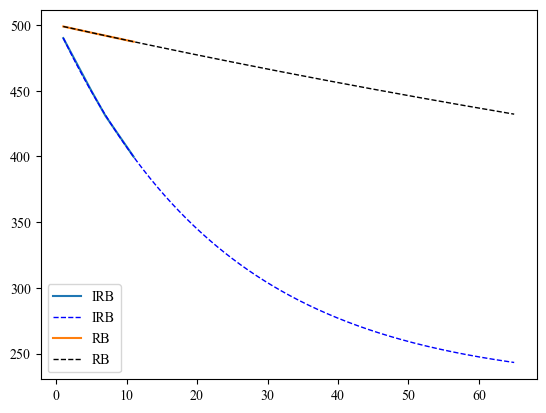

In [29]:

plt.plot(depths, 500*(np.real(survival_probs)), label='IRB')
plt.plot(depthss, 500*(probs_), 'b--', linewidth=1.0, label='IRB')
plt.plot(depths, 500*(np.real(rb_survival_probs)), label='RB')
plt.plot(depthss, 500*(rb_probs_), 'k--', linewidth=1.0, label='RB')
print("IRB", a, b, c)
print("RB", a_rb, b_rb, c_rb)
plt.legend()

In [349]:
p = b_rb
pC_ = b
dim = N**2
r_ext = (dim - 1)*(1 - pC_/p)/dim
1 - r_ext ##average gate fidelity.

0.9792598836421076

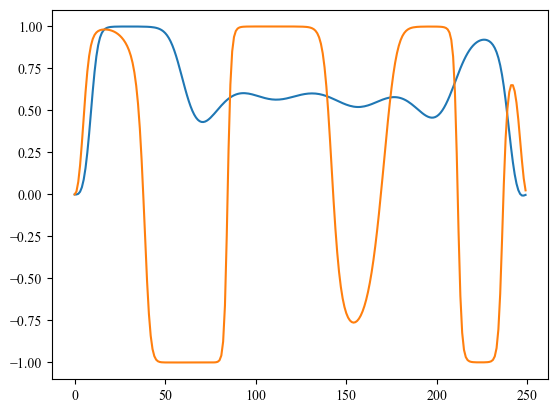

In [28]:
plt.plot(cnot_control_1)
plt.plot(cnot_control_2)

In [847]:
e1 = basis(N**2,0)
e2 = basis(N**2,1)
e3 = basis(N**2,N)
e4 = basis(N**2,N+1)
Total_Ucnot = Qobj(Total_Ucnot.full())
print(np.abs((Total_Ucnot*CNOT.dag()).tr())/4)
# CNOT_eff_ideal = (e1*e1.dag() + e2*e2.dag() + e3*e3.dag() + e4*e4.dag())*CNOT*(e1*e1.dag() + e2*e2.dag() + e3*e3.dag() + e4*e4.dag())
# CNOT_eff = (e1*e1.dag() + e2*e2.dag() + e3*e3.dag() + e4*e4.dag())*Ucnot*(e1*e1.dag() + e2*e2.dag() + e3*e3.dag() + e4*e4.dag())
# np.abs(e1.dag()*CNOT_eff*CNOT_eff_ideal.dag()*e1)

0.6797676334619815


In [350]:
b  = qutip.Bloch()

#Vizualising Blch sphere
#b.make_sphere()
b.view = [90,0]
b.clear()

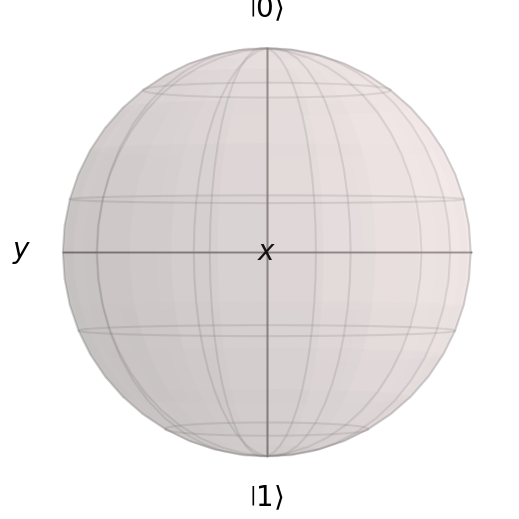

In [351]:

# b.make_sphere()
def plot(rho, num):
    eigenvalues, eigenvectors = np.linalg.eig(rho.full())
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue in descending order
    eigenvectors = eigenvectors[:, idx]  # Sort eigenvectors accordingly
    dominant_eigenvector = eigenvectors[:, 0]
    state = Qobj(dominant_eigenvector / np.linalg.norm(dominant_eigenvector))

    bloch_vector = [
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state)
    ]

    if(num==0):
        state=state.full()
        b.add_points(np.array(bloch_vector)[:, np.newaxis], 'm','c')
        b.render()
    #
    else:
        b.add_states(state)
        b.render()

# b.make_sphere()
rho = Qobj(np.array([[-9,10],[-12,8]]))#this is the input
#plot(rho,0)# if second parameter = 0, it will plot a point, if 1 it will plot a vector
b.show()

In [362]:
Qobj(((Qobj(Ucnot.full(),dims=[[3,3],[3,3]])*tensor(basis(N, 1),basis(N, 1))).ptrace(0)).full()[:2,:2])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.60887939e-04+0.j        2.42653623e-03-0.0063179j]
 [2.42653623e-03+0.0063179j 9.98589275e-01+0.j       ]]

In [363]:
Qobj(((Qobj(Ucnot.full(),dims=[[3,3],[3,3]])*tensor(basis(N, 1),basis(N, 1))).ptrace(1)).full()[:2,:2])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.99286686e-01+0.j         -1.75390329e-03-0.00856323j]
 [-1.75390329e-03+0.00856323j  4.01346441e-04+0.j        ]]